In [1]:
import axs
import numpy as np

from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u

import pandas as pd
import matplotlib.pyplot as plt

import pyspark.sql.functions as sparkfunc
import pyspark.sql.types as pyspark_types
import numpy as np

In [2]:
%matplotlib inline

# Setup spark

In [ ]:
def spark_start(local_dir):
    from pyspark.sql import SparkSession
    
    spark = (
            SparkSession.builder
            .appName("LSD2")
            .config("spark.sql.warehouse.dir", local_dir)
            .config('spark.master', "local[6]")
            .config('spark.driver.memory', '8G') # 128
            .config('spark.local.dir', local_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '4G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "6G")
            .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={local_dir}")
            .enableHiveSupport()
            .getOrCreate()
                    )   

    return spark

spark_session = spark_start("/epyc/users/kyboone/spark-tmp/")

catalog = axs.AxsCatalog(spark_session)


In [5]:
spark_session

Hovering over "Spark UI" above gives you the port number of the Spark web dashboard.  Epyc doesn't have that port open, though, so we use an SSH tunnel to forward the ports.  I like to put the following function into my `.bashrc` o my local machine:


```
function spark_tunnel()
{
        # this function takes one argument: the epyc port to tunnel
        # the ordering is backwards (requiring a manual refresh) because
        # I want to be able to manually kill the ssh tunnel
        open http://localhost:${1}/
        ssh -N -L ${1}:127.0.0.1:${1} username@epyc.astro.washington.edu
}
```

What tables does AXS know about?

# Load ZTF data

In [6]:
ztf = catalog.load('ztf_mar19_all')

# Plotting

In [3]:
def plot_lightcurve(row):
    plt.figure(figsize=(8, 6))

    for filterid in np.unique(row['filterid']):
        cut = (
            (np.array(row['filterid']) == filterid)
            & (np.array(row['catflags']) == 0.)
        )
        def cc(x):
            return np.array(x)[cut]
        plt.errorbar(cc(np.array(row['mjd'])), cc(row['psfmag']), cc(row['psfmagerr']), fmt='o', c='C%d' % filterid, label='Filter %d' % filterid)

    plt.xlabel('mjd')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.title('matchid %d' % row['matchid'])
    plt.gca().invert_yaxis()

# Dipper detection original

In [4]:
from scipy.ndimage import minimum_filter1d

def detect_dippers(mjd, filterid, psfmag, psfmagerr, xpos, ypos, catflags, verbose=False, return_mjd=False):
    if len(mjd) == 0:
        return 0.

    order = np.argsort(mjd)

    # Throw out repeated measurements.
    ordered_mjd = np.array(mjd)[order]
    mask = np.abs(ordered_mjd - np.roll(ordered_mjd, 1)) > 1e-5

    mjd = np.array(mjd)[order][mask]
    filterid = np.array(filterid)[order][mask]
    psfmag = np.array(psfmag)[order][mask]
    psfmagerr = np.array(psfmagerr)[order][mask]
    xpos = np.array(xpos)[order][mask]
    ypos = np.array(ypos)[order][mask]
    catflags = np.array(catflags)[order][mask]

    scores = np.zeros(len(psfmag))
    
    pad_width = 20
    x_border = 3072
    y_border = 3080

    for iter_filterid in np.unique(filterid):
        cut = (
            (filterid == iter_filterid)
            & (xpos > pad_width)
            & (xpos < x_border - pad_width)
            & (ypos > pad_width)
            & (ypos < y_border - pad_width)
            & (catflags == 0)
        )

        if np.sum(cut) < 10:
            # Require at least 10 observations to have reasonable statistics.
            continue

        use_psfmag = psfmag[cut]
        use_psfmagerr = psfmagerr[cut]
        
        core_std = np.std(use_psfmag)
        filter_scores = (use_psfmag - np.median(use_psfmag)) / np.sqrt(core_std**2 + use_psfmagerr**2)

        scores[cut] = filter_scores
                
    # Check for sequential runs.
    
    # Get the minimum score for a run.
    filtered_scores = minimum_filter1d(scores, 4, mode='constant')
        
    result = float(np.max(filtered_scores))
    max_mjd = mjd[np.argmax(filtered_scores)]

    if verbose:
        print("Max mjd: ", max_mjd)

    if return_mjd:
        return result, max_mjd
    else:
        return result

def detect_dippers_row(row, verbose=False, return_mjd=False):
    return detect_dippers(row['mjd'], row['filterid'], row['psfmag'],
                          row['psfmagerr'], row['xpos'], row['ypos'],
                          row['catflags'],
                          verbose=verbose, return_mjd=return_mjd)

# Create a UDF for spark
detect_dippers_udf = sparkfunc.udf(detect_dippers, returnType=pyspark_types.FloatType())

# Dipper detection with GroupBy MJD

In [5]:
from scipy.ndimage import minimum_filter1d

def detect_dippers(mjd, filterid, psfmag, psfmagerr, xpos, ypos, catflags, verbose=False, return_mjd=False):
    if len(mjd) == 0:
        return 0.

    order = np.argsort(mjd)

    # Throw out repeated measurements.
#     ordered_mjd = np.array(mjd)[order]
#     mask = np.abs(ordered_mjd - np.roll(ordered_mjd, 1)) > 1e-5

#     mjd = np.array(mjd)[order][mask]
#     filterid = np.array(filterid)[order][mask]
#     psfmag = np.array(psfmag)[order][mask]
#     psfmagerr = np.array(psfmagerr)[order][mask]
#     xpos = np.array(xpos)[order][mask]
#     ypos = np.array(ypos)[order][mask]
#     catflags = np.array(catflags)[order][mask]
    
    full_df = pd.DataFrame({'mjd':mjd,
                            'filterid':filterid,
                            'psfmag':psfmag,
                            'psfmagerr':psfmagerr,
                            'xpos':xpos,
                            'ypos':ypos,
                            'catflags':catflags})
    full_df = full_df.iloc[order]
    test_df = full_df.drop_duplicates(subset='mjd', inplace=False)
    
    pad_width = 20
    x_border = 3072
    y_border = 3080

#     cut = np.where(
#             (test_df['xpos'] > pad_width)
#             & (test_df['xpos'] < x_border - pad_width)
#             & (test_df['ypos'] > pad_width)
#             & (test_df['ypos'] < y_border - pad_width)
#             & (test_df['catflags'] == 0)
#         )
#     test_df = test_df.iloc[cut]
    test_df = test_df.query('xpos > %i and xpos < %i and ypos > %i and ypos < %i and catflags == %i' % 
                            (pad_width, (x_border - pad_width), pad_width, (y_border - pad_width), 0))[['mjd', 'filterid', 'psfmag', 'psfmagerr']].reset_index(drop=True)
    #test_df['scores'] = 0.
    test_df['mjd_base'] = np.array(np.floor(test_df['mjd']), dtype=np.int)
    grouped_df = test_df.groupby(['filterid', 'mjd_base']).mean().reset_index(drop=False)
    scores = np.zeros(len(grouped_df))

    for iter_filterid in np.unique(filterid):


        cut_df = grouped_df.query('filterid == %i' % iter_filterid)
        #cut_df = grouped_df.iloc[np.where(grouped_df['filterid'] == iter_filterid)]
        cut_idx = cut_df.index

        # if np.sum(cut) < 10:
        if len(cut_df) < 10:
            # Require at least 10 observations to have reasonable statistics.
            continue

        #use_psfmag = psfmag[cut]
        #use_psfmagerr = psfmagerr[cut]
        
        #test_df = pd.DataFrame({'mjd':mjd[cut], 'psfmag':psfmag[cut], 'psfmagerr':psfmagerr[cut]})
        
        
        use_psfmag = cut_df['psfmag'].values
        use_psfmagerr = cut_df['psfmagerr'].values
        
        core_std = np.std(use_psfmag)
        filter_scores = (use_psfmag - np.median(use_psfmag)) / np.sqrt(core_std**2 + use_psfmagerr**2)

        #grouped_df['scores'].iloc[cut_idx] = filter_scores
        #print(cut_df)
        #cut_df['scores'] = filter_scores
        scores[cut_idx] = filter_scores
                
    # Check for sequential runs.
    
    # Get the minimum score for a run.
    filtered_scores = minimum_filter1d(scores, 4, mode='constant')
        
    result = float(np.max(filtered_scores))
    max_mjd = grouped_df['mjd'][np.argmax(filtered_scores)]

    if verbose:
        print("Max mjd: ", max_mjd)

    if return_mjd:
        return result, max_mjd
    else:
        return result

def detect_dippers_row(row, verbose=False, return_mjd=False):
    return detect_dippers(row['mjd'], row['filterid'], row['psfmag'],
                          row['psfmagerr'], row['xpos'], row['ypos'],
                          row['catflags'],
                          verbose=verbose, return_mjd=return_mjd)

def detect_dippers_df(row):
    return pd.DataFrame({'mjd':row['mjd'], 'psfmag':row['psfmag'], 'psfmagerr':row['psfmagerr'], 'filter':row['filterid']})

# Create a UDF for spark
detect_dippers_udf = sparkfunc.udf(detect_dippers, returnType=pyspark_types.FloatType())

# Run the spark query

## Run and save the query

In [15]:
%%time

# Run on spark
res = (
    ztf.region(ra1=296, ra2=302, dec1=8, dec2=15)
    .exclude_duplicates()
    .where(sparkfunc.col("nobs_avail") > 20)
    .select(
        '*',
        detect_dippers_udf(ztf['mjd'], ztf['filterid'], ztf['psfmag'], ztf['psfmagerr'], ztf['xpos'], ztf['ypos'], ztf['catflags']).alias('score')
    )
    .where(sparkfunc.col("score") > 2.)
    .collect()
)
print(len(res))

import pickle
pickle.dump(res, open('test_query.pkl', 'wb'))

4189
CPU times: user 1.79 s, sys: 614 ms, total: 2.4 s
Wall time: 40min 9s


## Load the query results

In [6]:
import pickle

In [7]:
res = pickle.load(open('/epyc/data/boyajian/saved_queries/test_query.pkl', 'rb'))

# Analysis

In [8]:
%%time
#%%prun -s cumulative
# Order the light curves by their scores

scores = []
mjds = []

for i in res:
    score, mjd = detect_dippers_row(i, return_mjd=True)
    scores.append(score)
    mjds.append(mjd)

order = np.argsort(scores)[::-1]

# Apparently things break if you cast a list of spark objects into a numpy array,
# so keep everything as a list.
ordered_res = [res[i] for i in order]

CPU times: user 1min 13s, sys: 1.11 s, total: 1min 14s
Wall time: 1min 14s


idx: 0
Max mjd:  58432.0875
2.7311744319927693
ra: 297.948907
dec: 9.167114
xpos: 50.38, ypos: 2123.02
idx: 1
Max mjd:  58432.0875
2.6372731228104245
ra: 297.231730
dec: 9.545150
xpos: 2565.19, ypos: 770.68
idx: 2
Max mjd:  58474.08203415
2.6257465992851534
ra: 296.542737
dec: 8.452290
xpos: 1469.98, ypos: 1560.83
idx: 3
Max mjd:  58432.1666088
2.596924434446987
ra: 299.292050
dec: 12.458030
xpos: 1949.87, ypos: 952.21
idx: 4
Max mjd:  58242.4613426
2.593195427887704
ra: 298.665327
dec: 9.283784
xpos: 610.79, ypos: 1698.97


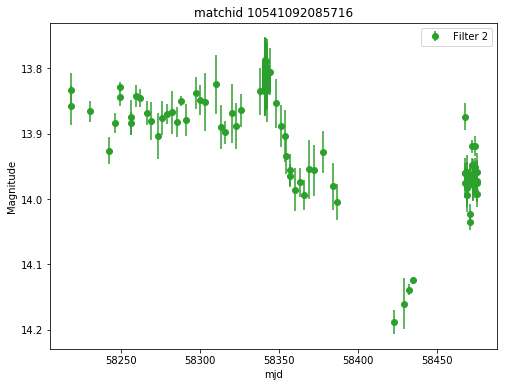

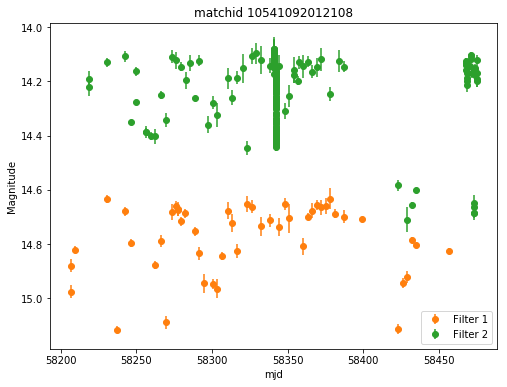

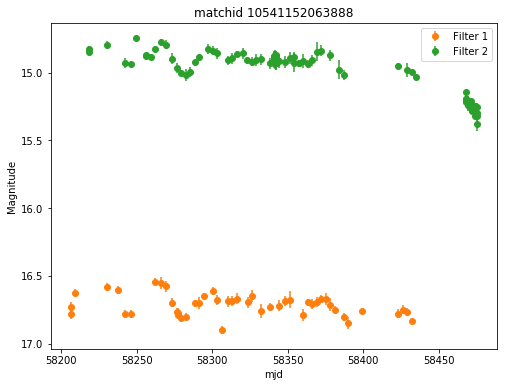

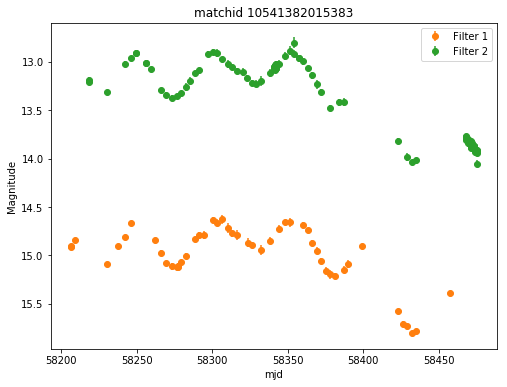

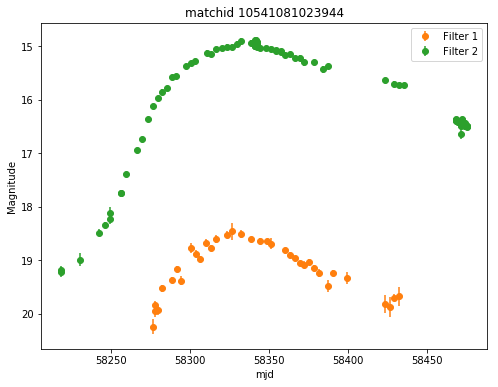

In [9]:
for idx in range(5):
    print("=================")
    row = ordered_res[idx]
    print("idx: %d" % idx)
    print(detect_dippers_row(row, verbose=True))
    print("ra: %.6f" % row['ra'])
    print("dec: %.6f" % row['dec'])
    print("xpos: %.2f, ypos: %.2f" % (np.mean(row['xpos']), np.mean(row['ypos'])))

    plot_lightcurve(row)

# Artifact investigation

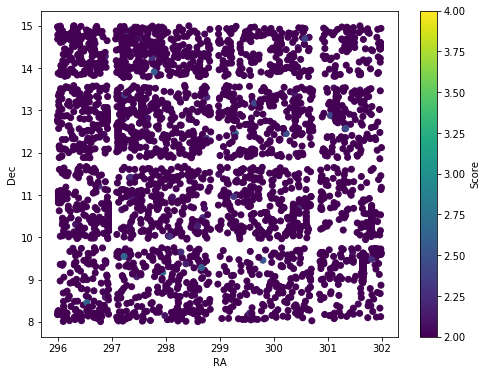

In [10]:
# Hmm, many of our dippers show up in a line on the sky!
ra = [i['ra'] for i in res]
dec = [i['dec'] for i in res]
xpos = [np.mean(i['xpos']) for i in res]

plt.figure(figsize=(8, 6))
plt.scatter(ra, dec, c = scores, vmin=2, vmax=4)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar(label='Score')

## Playing around with pandas moving windows

In [11]:
df_list = []

for i in res:
    df_list.append(detect_dippers_df(i))

In [12]:
from astropy.time import Time

In [13]:
test_num = 1246
test_df = df_list[test_num]

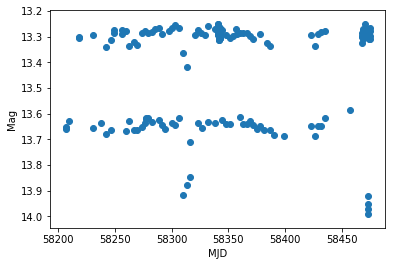

In [14]:
plt.scatter(test_df['mjd'], test_df['psfmag'])
plt.xlabel('MJD')
plt.ylabel('Mag')
plt.gca().invert_yaxis()

In [15]:
t = Time(test_df['mjd'], format='mjd')

In [16]:
t.iso

array(['2018-05-21 09:37:29.001', '2018-09-05 05:32:03.002',
       '2018-07-24 09:37:38.004', '2018-09-11 05:29:29.003',
       '2018-08-08 08:42:40.997', '2018-05-08 11:12:59.999',
       '2018-03-29 12:39:25.001', '2018-08-21 06:31:38.001',
       '2018-05-04 10:30:56.998', '2018-06-08 10:58:53.003',
       '2018-08-30 04:01:52.997', '2018-08-18 08:26:21.998',
       '2018-08-14 08:09:10.996', '2018-07-04 09:36:48.997',
       '2018-09-08 05:32:18.001', '2018-07-11 08:02:59.001',
       '2018-07-01 10:41:06.999', '2018-07-14 08:33:13.997',
       '2018-06-10 10:39:05.996', '2018-04-22 11:56:56.003',
       '2018-06-04 10:58:23.998', '2018-06-07 09:57:52.001',
       '2018-06-25 10:41:00.001', '2018-07-27 10:20:39.998',
       '2018-07-07 08:07:12.999', '2018-10-08 02:32:11.003',
       '2018-06-19 09:58:08.003', '2018-12-05 02:22:26.999',
       '2018-06-22 10:30:33.998', '2018-09-02 04:36:51.998',
       '2018-07-17 09:04:03.000', '2018-08-02 05:38:56.003',
       '2018-04-01 12:12

In [17]:
np.argsort(t.mjd)

array([ 42,   6,  32, 100,  74, 132,  19,  36,   8, 110, 124,   5, 146,
       108, 104, 126,   0, 130,  72,  43,  56,  40,  76,  38,  54,  20,
        21,  50,  47,   9,  78,  18,  37,  96,  60,  26,  52, 148,  28,
        22, 152,  62,  16,  66,  13,  24,  58,  15,  80,  17,  70, 150,
        30,  64,  82,   2,  84,  23,  88,  31,  94,  68,   4, 166, 170,
       196, 195, 171, 169, 172, 176, 252, 151,  85, 215, 277, 218, 143,
       217, 219, 279, 296,  95,  63, 103, 147,  81,  69,  87, 214, 225,
       204, 233, 229, 243, 251, 272, 235, 237, 205, 231, 232, 230, 234,
       278, 216, 121, 123, 129, 125, 127, 117, 131,  79, 208, 221, 226,
        55, 138, 222, 213, 248, 209, 167, 212, 207, 270, 113, 115, 210,
       157, 202, 159, 158, 156, 161, 160, 187, 191, 188, 198, 200, 111,
       165, 163, 190, 189, 168, 211, 287, 291, 119, 289, 292, 250, 298,
       294, 177, 285, 263, 286, 293, 275, 238, 247, 249, 227, 228, 236,
       203, 239, 295, 242, 241, 244, 240, 245, 246, 141, 193, 13

In [18]:
test_df = test_df.iloc[np.argsort(t.mjd)]
sorted_times = t[np.argsort(t.mjd)]

In [19]:
pd_times = [pd.Timestamp(x) for x in sorted_times.iso]

In [20]:
test_df['time'] = pd_times

/epyc/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
test_df.head()

,mjd,psfmag,psfmagerr,filter,time
42,58206.485324,13.650044,0.029,1,2018-03-29 11:38:52.002
6,58206.527373,13.660621,0.021,1,2018-03-29 12:39:25.001
32,58209.508843,13.627706,0.019,1,2018-04-01 12:12:44.001
100,58218.488148,13.304307,0.027,2,2018-04-10 11:42:55.996
74,58218.508518,13.300396,0.024,2,2018-04-10 12:12:15.998


In [22]:
test_df['mjd_base'] = np.array(np.floor(test_df['mjd']), dtype=np.int)

/epyc/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
test_df.head()

,mjd,psfmag,psfmagerr,filter,time,mjd_base
42,58206.485324,13.650044,0.029,1,2018-03-29 11:38:52.002,58206
6,58206.527373,13.660621,0.021,1,2018-03-29 12:39:25.001,58206
32,58209.508843,13.627706,0.019,1,2018-04-01 12:12:44.001,58209
100,58218.488148,13.304307,0.027,2,2018-04-10 11:42:55.996,58218
74,58218.508518,13.300396,0.024,2,2018-04-10 12:12:15.998,58218


In [24]:
grouped_df = test_df.groupby(['filter', 'mjd_base']).mean()

In [25]:
#grouped_df = test_df.groupby(['filter', 'mjd_base']).count()

In [26]:
grouped_df.head()

mjd     psfmag  psfmagerr
filter mjd_base                                    
1      58206     58206.506348  13.655333      0.025
       58209     58209.508843  13.627706      0.019
       58230     58230.497870  13.656298      0.014
       58237     58237.398449  13.635439      0.012
       58242     58242.438160  13.679806      0.019

(58450, 58500)

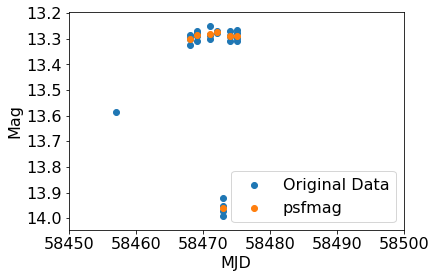

In [27]:
plt.scatter(test_df['mjd'], test_df['psfmag'], label='Original Data')
plt.scatter(grouped_df.query('filter==2')['mjd'], grouped_df.query('filter==2')['psfmag'])
plt.xlabel('MJD', size=16)
plt.ylabel('Mag', size=16)
plt.xticks(size=16)
plt.yticks(size=16)
plt.gca().invert_yaxis()
plt.legend(fontsize=16)
plt.xlim(58450, 58500)

In [28]:
one_day_mean = test_df.rolling('12h', on='time').mean()

(58450, 58500)

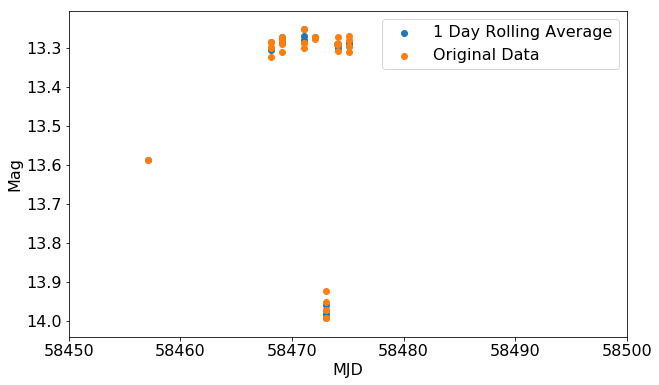

In [29]:
fig = plt.figure(figsize=(10, 6))
plt.scatter(sorted_times.mjd, one_day_mean['psfmag'], label='1 Day Rolling Average')
plt.scatter(test_df['mjd'], test_df['psfmag'], label='Original Data')
plt.xlabel('MJD', size=16)
plt.ylabel('Mag', size=16)
plt.xticks(size=16)
plt.yticks(size=16)
plt.gca().invert_yaxis()
plt.legend(fontsize=16)
plt.xlim(58450, 58500)